In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
#plt.style.use('ggplot')
%precision 4
#np.set_printoptions(suppress=True)

'%.4f'

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

Text(0.5, 1.0, 'number of Tl and Pb atoms as function of time')

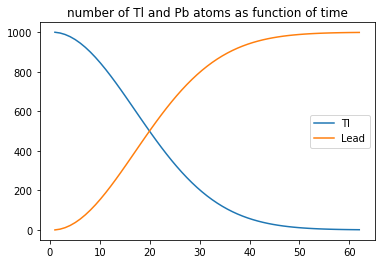

In [2]:
T = 3.052*60
p = lambda t : 1 - 2**(-t/T) 

nb_tl = [] # list of number of Tl
nb_pb = [] # list of number of Pb
t=1 # 1 second

# Add the values at t=0
nb_tl.append(1000)
nb_pb.append(0)

# each step (second), change the number of atoms of tl and lead
while nb_pb[t-1] < 999 :
    decays = nb_tl[t-1]*p(t)
    nb_tl.append(nb_tl[t-1]-decays)
    nb_pb.append(nb_pb[t-1]+decays)    
    t=t+1

# Plot the evolution of the two sets as a function of time
time = np.linspace(1,len(nb_pb)+1,len(nb_pb))
plt.plot(time,nb_tl, label = 'Tl')
plt.plot(time,nb_pb, label = 'Lead')
plt.legend()
plt.title("number of Tl and Pb atoms as function of time")



No handles with labels found to put in legend.


Text(0.5, 1.0, "number of atoms who don't decays as function of time")

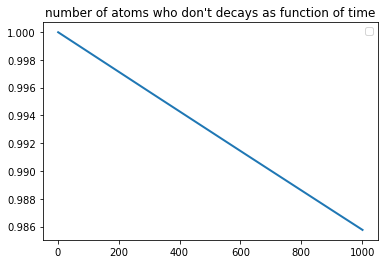

In [3]:
# with means of the inverse transform method
p2 = lambda t : 2**(((-t/T)*np.log(2))/T)

time = np.linspace(1,1001,1000)
u = np.random.random(1000)
v = p2(time)
plt.plot(time,v, linewidth=2)
plt.legend()
plt.title("number of atoms who don't decays as function of time")



2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [4]:
import math
import scipy.constants 
import random 
E=7.7
e=math.exp(1)
pi = math.pi
Z=79
[a,x,z]=scipy.constants.physical_constants['Bohr radius']
sigma=a/100
mu=0.5
e0=scipy.constants.epsilon_0


count =0

for i in range(0,1000000):
    b= np.random.normal(mu, sigma)*np.random.normal(0, sigma)
    tan = (Z*e**2)/(2*pi*e0*E*b)
    if np.arctan(tan*2>(pi/2)):
        count=count+1

print("fraction of particles that 'bounce back' :",count/1000000)

fraction of particles that 'bounce back' : 0.499817


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

hit/miss method I: 1.446
mean value method I: 1.4507104526733072
difference :  0.004710452673307275


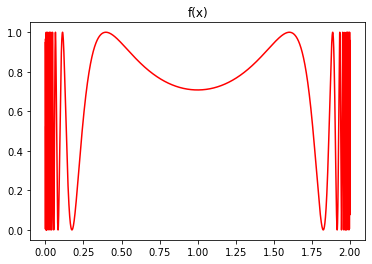

In [5]:
def f(x):
    return np.sin(1/(x*(2-x)))**2


a=0.00001
b=1.9999
N=10000

x=np.linspace(a,b,N)
plt.plot(x,f(x),'r-')
plt.title("f(x)")

# Monte Carlo integration hit/miss
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I1=2*count/N
print("hit/miss method I:",I1)

# Monte Carlo integration mean value

a=0.00001
b=1.9999
x=np.linspace(a,b,N)


I2 = ((b-a)/N )*np.sum(f(x))
print("mean value method I:",I2)

# Difference 
print("difference : ", abs(I1-I2))
# the mean value is more accurate

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



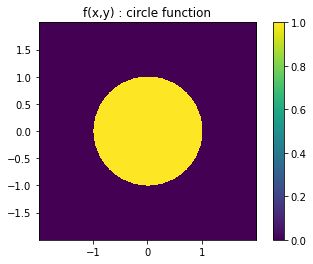

I :  3.1354944270395206
10D I :  1.024


In [43]:
def f(x,y):
    res = x**2+y**2 
    res[res<=1]=1
    res[res>1]=0
    return res
    
a=-1.9999
b=1.9999
N=1000
x = np.linspace(a,b,N)
y = np.linspace(a,b,N)

# meshgrid
xx, yy = np.meshgrid(x, y, sparse=True)
z = f(xx,yy) 
# pylab.imshow() 
import matplotlib.cm as cm
im = plt.imshow(z, interpolation='none',origin='lower', extent=[a,b, a, b])
plt.colorbar()
plt.title("f(x,y) : circle function")
plt.show()

# Integration of f(x,y)
Ix = ((b-a)/N )*np.sum(z) # integration x
I2 = ((b-a)/N )*np.sum(Ix) # integration y
print("I : ",I2) 

# Integration of a 10D sphere

def spherearea(D, N):
    count = 0

    for i in range(N):
        point = np.random.uniform(-1, 1, D)
        distance = np.linalg.norm(point)
        if distance < 1.0: count+=1
    
    return 2**D *count/N

print( "10D I : ",spherearea(10, N))

5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [62]:
def w(x) :
    return 1/np.sqrt(x)

def f(x) :
    return 1 / ((np.exp(x) + 1)*x)

a=0.0001
b=0.9999
N=1000

x = np.linspace(a, b, N)

I = (1/N)*np.sum(f(x)/w(x)) 

print("I =",I)

I = 0.8632994805818476
